# <span style='color:SteelBlue'>P6 - Classifiez automatiquement des biens de consommation (part 3)</span>

<img src="https://logo-marque.com/wp-content/uploads/2020/11/Flipkart-Logo.png" width="300" height="200">

# <span style='background:red; color:black'>a MAJ</span>

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies utilisees dans ce notebook <br>

Paramètres d'affichage du notebook <br>

Fonctions utilisees dans ce notebook <br>

Importation des données <br>

**Etape 1 : Description des donnees**
- _1/ etc...


Conclusion

# <span style='background:blue'>Introduction</span>

L'entreprise **"Flipkart"** est une entreprise indienne qui souhaite lancer une
marketplace e-commerce. Sur cette place de marché anglophone, des vendeurs
proposent des articles à des acheteurs en postant une photo et une description.
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne
de nouveaux articles) et des acheteurs (faciliter la recherche de produits) 
la plus fluide possible, et dans l'optique d'un passage à l'échelle, 
il devient nécessaire **d'automatiser l'attribution de la catégorie** d'un 
article (actuellement effectuée manuellement par les vendeurs, donc peu 
fiable).
___
**Missions**<br>
1/ Faire une **étude de la faisabilité d’un moteur de classification**
d’article basé sur une **description** pour automatiser l’attribution
de catégorie de l’article. 

2/ Faire une **étude de la faisabilité d’un moteur de classification**
d’article basé sur une **image** pour automatiser l’attribution
de catégorie de l’article. 

3/ **Réaliser une classification supervisée** à partir des images par la mise
en place d’une data augmentation afin d’optimiser le modèle. 

4/ **Extraire les 10 premiers produits à base de « champagne »** issus de
l’API fournie dans un fichier “.csv”, contenant pour chaque produit les
données suivantes : foodId, label, category, foodContentsLabel, image.
___
Ce notebook presente la 3ème partie concernant la réalisation de la
classification supervisée à partir des images par la mise en place d’une
data augmentation afin d’optimiser le modèle.

# <span style='background:red'>a terminer</span>

___
**Source des datasets**<br>
Source : Non précisé<br>
___

<div class="alert alert-block alert-warning">
<b>Formattage du notebook au PEP8 => lancer cette ligne de code dans le
terminal VSC : </b><br>
nbqa black Berthe_Pierrick_1_notebook_exploration_112023.ipynb</div>

# <span style='background:grey'>Importations des librairies utilisees dans ce notebook</span>

In [81]:
# Librairies generales
import os.path
import sys
from IPython.display import display
import time
from datetime import datetime
import pyopencl as cl

# Librairies data science
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image

# deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import Input
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from plot_keras_history import show_history, plot_history

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print("Version des librairies utilisees :")
print("Python        : " + sys.version)
print("Matplotlib    : " + mpl.__version__)
print("NumPy         : " + np.version.full_version)
print("Pandas        : " + pd.__version__)
print("Seaborn       : " + sns.__version__)
print("Tensorflow    : " + tf.__version__)

# Nombre de coeurs
nbr_coeur = os.cpu_count()
print(f"\nNombre de coeur disponible(s) sur ce PC: {nbr_coeur} coeur(s)")

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Activer la verification PEP8
print("")
%load_ext pycodestyle_magic
%pycodestyle_on

Version des librairies utilisees :
Python        : 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Matplotlib    : 3.8.2
NumPy         : 1.26.2
Pandas        : 2.1.4
Seaborn       : 0.13.0
Tensorflow    : 2.15.0

Nombre de coeur disponible(s) sur ce PC: 12 coeur(s)

Code lance le : 2024-01-25T16:53:38.241787

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


<div class="alert alert-block alert-warning">
<b>Formattage du notebook au PEP8 => lancer cette ligne de code dans le 
terminal VSC : </b> <br>
nbqa black nom_fichier.ipynb</div>

# <span style='background:grey'>Paramètres d'affichage</span>

In [2]:
# parametrage des paramètres d'affichage dans le notebook
pd.set_option("display.max_row", 50)
pd.set_option("display.max_column", 50)
pd.set_option("display.precision", 2)

# Ignorer les messages d'avertissement de tensorflow
tf.get_logger().setLevel('ERROR')

# Desactiver la limite de taille des images
Image.MAX_IMAGE_PIXELS = None

# <span style='background:grey'>Fonctions</span>

In [3]:
def calculer_duree_notebook(start_time):
    """
    Cette procédure calcule et affiche la durée totale depuis un temps de
    début donné.

    Args:
        start_time (float): Le temps de début en secondes depuis l'époque.

    Returns:
        None
    """

    # Calculer la durée totale
    total_time = time.time() - start_time

    # Convertir en minutes et secondes
    minutes, seconds = divmod(total_time, 60)

    # Afficher la durée totale
    message = (
        "Durée totale pour faire tourner le notebook : "
        "{0} minute(s) {1} seconde(s)"
    )
    print(message.format(int(minutes), int(seconds)))

In [122]:
def image_prep_fct(data, model_type):
    """
    Cette fonction prépare les images pour l'entraînement d'un modèle de
    machine learning. Si le modèle est de type VGG-16, un prétraitement
    spécifique est appliqué.

    Paramètres :
    data (DataFrame) : DataFrame contenant les chemins d'accès aux images
    dans la colonne 'image'.
    model_type (str) : Le type de modèle pour lequel les images sont préparées.
        Si 'vgg16', le prétraitement spécifique à VGG-16 est appliqué.

    Retourne :
    prepared_images_np (ndarray) : Tableau NumPy des images préparées.
    """

    # Initialisation de la liste pour stocker les images préparées
    prepared_images = []

    # Parcours de chaque chemin d'image dans data['image']
    for image_num in range(len(data)):

        # Chargement et redimensionnement de l'image en 224 x 224 pixels
        img = (load_img(data[image_num], target_size=(224, 224)))

        # Conversion de l'image en tableau NumPy
        img = img_to_array(img)

        # Redimensionnement tableau de l'image pour certifier les 3 dimensions
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))

        # Pré-traitement de l'image pour VGG-16 (si applicable)
        if model_type == 'vgg16':
            img = preprocess_input(img)

        # Ajout de l'image préparée à la liste
        prepared_images.append(img)

    # Conversion de la liste en tableau NumPy
    prepared_images_np = np.array(prepared_images)

    return prepared_images_np

In [86]:
def creation_modele_mlp():
    """
    Cette fonction crée et compile un modèle de réseau de neurones à
    plusieurs couches (MLP) avec Keras. Le modèle est conçu pour des données
    d'entrée de forme (224, 224, 3).

    Le modèle a la structure suivante :
    - 1 couche d'entrée de forme (224, 224, 3)
    - 1 couche Flatten pour aplatir les données d'entrée
    - 2 couches Dense avec 10 neurones chacune et 1 fonction d'activation ReLU
    - 1 couche Dense avec 7 neurones et une fonction d'activation sigmoid

    Le modèle est compilé avec la fonction de perte 'categorical_crossentropy',
    l'optimiseur 'rmsprop' et la métrique 'accuracy'.

    Retourne :
    Le modèle MLP compilé.
    """
    # Créer le modèle
    model_mlp = Sequential()
    model_mlp.add(Input(shape=(224, 224, 3)))
    model_mlp.add(Flatten())
    model_mlp.add(Dense(10, activation='relu'))
    model_mlp.add(Dense(10, activation='relu'))
    model_mlp.add(Dense(7, activation='sigmoid'))

    # Compiler le modèle
    model_mlp.compile(
        loss='categorical_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
        )

    # Afficher un résumé du modèle
    print(model_mlp.summary())

    return model_mlp

In [5]:
def creation_modele_transfer_vgg16():
    """
    Crée un modèle de classification d'images basé sur le modèle pré-entraîné
    VGG16. Le modèle VGG16 est utilisé comme extracteur de caractéristiques,
    et de nouvelles couches sont ajoutées pour la classification.

    Les poids du modèle VGG16 sont initialisés avec les poids appris sur
    ImageNet et ne sont pas mis à jour pendant l'entraînement.

    Le nouveau modèle est compilé avec la perte de cross-entropie catégorielle,
    l'optimiseur RMSprop et la précision comme métrique.

    Retourne:
        model: Le modèle créé.
    """
    # Récupération du modèle pré-entraîné VGG16 sans les couches supérieures
    model0 = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
        )

    # Rendre les couches du modèle VGG16 non entraînables
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie du modèle VGG16
    x = model0.output

    # Completer model : vecteur 1D / ReLU / desactive moitié / softmax 7 cate
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Créer le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)

    # Compiler le modèle : perte a minimiser / optimiseur / métrique evaluation
    model.compile(
        loss="categorical_crossentropy",
        optimizer='rmsprop',
        metrics=["accuracy"]
        )

    # Afficher un résumé du modèle
    print(model.summary())

    return model

In [95]:
def creer_callbacks(nom_modele):
    """
    Cette fonction crée une liste de callbacks pour l'entraînement d'un modèle
    Keras. Les callbacks incluent un checkpoint pour enregistrer les meilleurs
    poids du modèle (lorsque val_loss est minimale) et un EarlyStopping pour
    arrêter l'entraînement si val_loss ne diminue plus après 3 epochs.

    Paramètres :
    nom_modele (str) : Le nom du modèle. Utilisé pour nommer le fichier de
    poids exporté.

    Retourne :
    callbacks_list (list) : Liste des callbacks à utiliser lors de
    l'entraînement du modèle.
    chemin_modele_export (str) : Chemin d'exportation du modèle.
    """
    # Définir le chemin d'exportation du modèle
    chemin_modele_export = f"./modele_ML/{nom_modele}_best_weights.h5"

    # Callback 1 : Enregistrer le meilleur modèle (poids quand val_loss min)
    checkpoint = ModelCheckpoint(
        chemin_modele_export,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

    # Callback 2 : stop entrainement si val_loss ne diminue plus apres 3 epochs
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

    # Assigner les callbacks à une liste
    callbacks_list = [checkpoint, es]

    return callbacks_list, chemin_modele_export

In [6]:
def conf_mat_transform_argmax(y_true, y_pred):
    """
    Transforme les labels prédits en utilisant la valeur maximale de chaque
    colonne.

    Paramètres:
    y_true (array-like): Les vrais labels.
    y_pred (array-like): Les labels prédits.

    Retourne:
    y_pred_transform (Series): Les labels prédits transformés.
    """

    # Calculer la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_true, y_pred)

    # Calcule les correspondances (valeurs max de chaque colonne)
    corresp = np.argmax(conf_mat, axis=0)
    print("\nCorrespondance des clusters : ", corresp)

    # Créer un DataFrame avec les vrais labels et les labels prédits
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred

    # Transformer les labels prédits en utilisant la correspondance
    labels['y_pred_transform'] = labels['y_pred'].apply(
        lambda x: corresp[x] if x < len(corresp) else x)

    # Retourner les labels prédits transformés
    return labels['y_pred_transform']

In [7]:
# class TrainingPlot(Callback):
#     """
#     Cette classe hérite de la classe Callback de Keras et permet de tracer
#     l'évolution de la perte et de l'exactitude
#     pendant l'entraînement d'un modèle de deep learning.
#     """

#     def on_train_begin(self, logs={}):
#         """
#         Cette fonction est appelée quand l'entraînement commence.
#         Elle initialise les listes pour stocker les valeurs de perte et
#         d'exactitude, et crée une figure pour le tracé.
#         """
#         self.losses = []
#         self.acc = []
#         self.val_losses = []
#         self.val_acc = []
#         self.fig = plt.figure()
#         self.logs = []

#     def on_epoch_end(self, epoch, logs={}):
#         """
#         Cette fonction est appelée à la fin de chaque époque.
#         Elle enregistre les valeurs de perte et d'exactitude de l'époque, et
#         met à jour le tracé.
#         """
#         self.logs.append(logs)
#         self.losses.append(logs.get('loss'))
#         self.acc.append(logs.get('accuracy'))
#         self.val_losses.append(logs.get('val_loss'))
#         self.val_acc.append(logs.get('val_accuracy'))

#         self.fig.clf()
#         ax1 = self.fig.add_subplot(121)
#         ax2 = self.fig.add_subplot(122)

#         # Plot 1 : Loss
#         ax1.plot(
#             range(1, len(self.losses) + 1),
#             self.losses,
#             label='Training Loss'
#             )
#         ax1.plot(
#             range(1, len(self.val_losses) + 1),
#             self.val_losses,
#             label='Validation Loss'
#             )
#         ax1.set_title('Loss')
#         ax1.set_xlabel('Epochs')
#         ax1.legend()

#         # Plot 2 : Accuracy
#         ax2.plot(
#             range(1, len(self.acc) + 1),
#             self.acc,
#             label='Training Accuracy'
#             )
#         ax2.plot(
#             range(1, len(self.val_acc) + 1),
#             self.val_acc,
#             label='Validation Accuracy'
#             )
#         ax2.set_title('Accuracy')
#         ax2.set_xlabel('Epochs')
#         ax2.legend()

#         # Forcer l'affichage du graphique
#         plt.draw()
#         plt.pause(0.01)

#         # Afficher le graphique
#         plt.show()

In [8]:
def get_available_amd_gpus():
    """
    Cette fonction renvoie une liste des GPU AMD disponibles sur la machine.

    Elle utilise la bibliothèque pyopencl pour obtenir une liste des
    plateformes disponibles,
    puis vérifie chaque plateforme pour voir si elle est fournie par AMD.
    Si c'est le cas, elle vérifie chaque device sur la plateforme pour voir
    s'il s'agit d'un GPU,
    et si c'est le cas, elle l'ajoute à la liste des GPU.

    Retourne :
        Une liste des objets pyopencl.Device pour les GPU AMD disponibles.
    """
    # Obtenir une liste de toutes les plateformes disponibles
    platforms = cl.get_platforms()

    # Initialiser une liste vide pour stocker les GPU AMD
    gpu_devices = []

    # Parcourir chaque plateforme
    for platform in platforms:

        # Vérifier si la plateforme est fournie par AMD
        amd_vendor = 'Advanced Micro Devices, Inc.'
        if platform.get_info(cl.platform_info.VENDOR) == amd_vendor:

            # Parcourir chaque device sur la plateforme
            for device in platform.get_devices():

                # Vérifier si le device est un GPU
                if device.type == cl.device_type.GPU:

                    # Si c'est un GPU, l'ajouter à la liste des GPU
                    gpu_devices.append(device)

    # Retourner la liste des GPU AMD
    return gpu_devices

In [61]:
def matrice_conf_et_rapport(y_val_num, y_val_pred_transform, categories):
    """
    Affiche la matrice de confusion et le rapport de classification pour les
    valeurs prédites et réelles.

    Paramètres:
    y_val_num (array): Les valeurs réelles.
    y_val_pred_transform (array): Les valeurs prédites.
    categories (list): Les catégories pour les axes de la matrice de confusion.

    Retourne:
    conf_mat_trans_df (DataFrame): La matrice de confusion.
    """
    # Creer la matrice de confusion
    conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)

    # Transformation en dataFrame
    conf_mat_trans_df = pd.DataFrame(
        conf_mat,
        index=[label for label in sorted(categories)],
        columns=[label for label in sorted(categories)]
        )

    # Afficher la matrice de confusion
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_mat_trans_df, annot=True, cmap="Blues")
    plt.title('Matrice de confusion')
    plt.xlabel('Catégories réelles')
    plt.ylabel('Catégories prédites')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # Afficher le rapport de classification
    print(metrics.classification_report(
        y_val_num,
        y_val_pred_transform,
        zero_division=1
        )
        )

    return conf_mat_trans_df

# <span style='background:grey'>Importation des donnees</span>

Importation du fichier CSV d'extraction image avec Pandas

In [9]:
# Definir le chemin d'import des fichiers
dossier_import = "./data/cleaned/"
nom_fichier = "extraction_feature_image.csv"
chemin_fichier_import = os.path.join(dossier_import, nom_fichier)

# Obtenir une liste de tous les fichiers dans le repertoire
fichiers = os.listdir(dossier_import)

# Initialiser un dictionnaire vide et display de la liste des fichiers importe
df_image = pd.read_csv(chemin_fichier_import, sep="\t", encoding="utf-8")
print(f"===> fichier '{nom_fichier}' importé: <====\n")

# Aperçu du dataframe
display(df_image)

===> fichier 'extraction_feature_image.csv' importé: <====



,image,product_name,label
0,./data/source/Images/55b85ea15a1536d46b7190ad6...,Home Furnishing,4
1,./data/source/Images/7b72c92c2f6c40268628ec5f1...,Baby Care,0
2,./data/source/Images/64d5d4a258243731dc7bbb1ee...,Baby Care,0
3,./data/source/Images/d4684dcdc759dd9cdf4150469...,Home Furnishing,4
4,./data/source/Images/6325b6870c54cd47be6ebfbff...,Home Furnishing,4
...,...,...,...
1045,./data/source/Images/958f54f4c46b53c8a0a9b8167...,Baby Care,0
1046,./data/source/Images/fd6cbcc22efb6b761bd564c28...,Baby Care,0
1047,./data/source/Images/5912e037d12774bb73a2048f3...,Baby Care,0
1048,./data/source/Images/c3edc504d1b4f0ba6224fa53a...,Baby Care,0


# <span style='background:blue'>Etape 1 : Séparation des données</span>

Nous divisons les données en 3 jeux de données :
- 75% des données pour le **train**
- 15% des données pour la **validation**
- 15% des données pour le **test**

Nous définissons les variables X et y pour l'entrainement du modèle:
- Les **features** (X) sont les tableau NumPy des images.
- La **target** (Y) est la colonne "label" du dataframe.

In [113]:
X = df_image['image'].values
y = to_categorical(df_image['label'])

In [114]:
display(X)

array(['./data/source/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg',
       './data/source/Images/7b72c92c2f6c40268628ec5f14c6d590.jpg',
       './data/source/Images/64d5d4a258243731dc7bbb1eef49ad74.jpg', ...,
       './data/source/Images/5912e037d12774bb73a2048f35a00009.jpg',
       './data/source/Images/c3edc504d1b4f0ba6224fa53a43a7ad6.jpg',
       './data/source/Images/f2f027ad6a6df617c9f125173da71e44.jpg'],
      dtype=object)

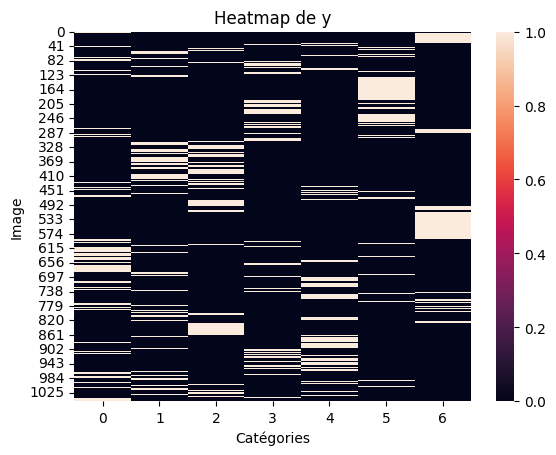

In [117]:
# Créer un heatmap de y
sns.heatmap(y)
plt.title('Heatmap de y')
plt.xlabel('Catégories')
plt.ylabel('Image')
plt.show()

In [116]:
# Séparation des données entraînement+validation / test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
    )

# Séparation des données entraînement / validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.176,
    random_state=42,
    stratify=y_train_val
    )

# Affichage des dimensions des données
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (735,)
X_val shape: (157,)
X_test shape: (158,)


Nous isolons le nom des catégories dans une variable "categories" pour
la suite du notebook.

In [118]:
categories = df_image['product_name'].unique()

# <span style='background:blue'>Etape 1 : MLP</span>

Pour cette classification d'image automatique, nous allons utiliser un
**perceptron multicouche** (*MultiLayer Perceptron*, **MLP**) comme modèle de
modèle de référence. 

## <span style='background:green'>1/ Prétraitement des données</span>

Nous appliquons un prétraitement des données pour les mettre dans un format
adapté au modèle de classification supervisée avec un VGG16.

Le pre-processing des images pour VGG-16 consiste à :
- Convertir l'image en tableau NumPy (si necessaire)
- Normaliser les pixels de l'image pour VGG-16 :
    - Mettre à l'echelle entre -1 et 1 (soustraire valeur moyenne des
    des pixels sur le canaux RGB du jeu de données ImageNet)
    - inverser les canaux RGB en BGR

In [125]:
# Préparer les données d'entrainement
X_train_np = image_prep_fct(X_train, 'mlp_cnn')
print("X_train_np : ", X_train_np.shape)

# Préparer les données de validation
X_val_np = image_prep_fct(X_val, 'mlp_cnn')
print("X_val_np : ", X_val_np.shape)

# Préparer les données de test
X_test_np = image_prep_fct(X_test, 'mlp_cnn')
print("X_test_np : ", X_test_np.shape)

X_train_np :  (735, 224, 224, 3)
X_val_np :  (157, 224, 224, 3)
X_test_np :  (158, 224, 224, 3)


## <span style='background:green'>1/ création du modèle</span>

Le modèle MLP a la structure suivante :
- 1 couche d'entrée de forme (224, 224, 3)
- 1 couche Flatten pour aplatir les données d'entrée
- 2 couches Dense avec 10 neurones chacune et 1 fonction d'activation ReLU
- 1 couche Dense avec 7 neurones et une fonction d'activation sigmoid

Le modèle est compilé avec :
- la fonction de perte '**categorical_crossentropy**'
- l'optimiseur '**rmsprop**'
- la métrique '**accuracy**'.

In [99]:
# Afficher les GPU AMD disponibles
amd_gpus = get_available_amd_gpus()
print("Nombre de GPU AMD disponibles : ", len(amd_gpus), "\n")

# Créer un modèle MLP
model_mlp = creation_modele_mlp()

Nombre de GPU AMD disponibles :  1 

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 150528)            0         
                                                                 
 dense_64 (Dense)            (None, 10)                1505290   
                                                                 
 dense_65 (Dense)            (None, 10)                110       
                                                                 
 dense_66 (Dense)            (None, 7)                 77        
                                                                 
Total params: 1505477 (5.74 MB)
Trainable params: 1505477 (5.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## <span style='background:green'>2/ Création des callbacks</span>

Nous créeons 2 callbacks :
- **ModelCheckpoint** pour sauvegarder le meilleur modèle pendant
l'entrainement
- **EarlyStopping** pour arrêter l'entrainement si val_loss ne diminue plus
après 3 epochs

In [98]:
callbacks_list, chemin_modele_export = creer_callbacks("model_mlp")

## <span style='background:green'>3/ entrainement du modèle</span>


In [89]:
# Définir les tailles de lot à tester
batch_sizes = [32, 64, 128, 256, 512]

# Créer des dictionnaires vides pour stocker l'historique et le temps
history_dict, time_dict = {}, {}

# POUR chaque batch_size
for batch_size in batch_sizes:
    print("\n", "=" * 30, "batch_size :", batch_size, "=" * 30)

    # Utiliser le GPU
    with tf.device('/gpu:0'):

        # Créer un modèle MLP
        model_mlp = creation_modele_mlp()

        # Enregistrer le temps de début
        start_time = time.time()

        # Entraîner le modèle
        history_mlp = model_mlp.fit(
            X_train,
            y_train,
            epochs=15,
            batch_size=batch_size,
            callbacks=callbacks_list,
            validation_data=(X_val, y_val),
            verbose=0
            )

        # Enregistrer le temps de fin
        end_time = time.time()

        # Calculer le temps d'entraînement
        training_time = end_time - start_time
        print(f"\n=>Temps d'entraînement : {round(training_time, 2)} sec<=")

    # Stocker l'historique et le temps d'entraînement
    history_dict[batch_size] = history_mlp.history
    time_dict[batch_size] = training_time

Nombre de GPU AMD disponibles :  1 


 ==================== batch_size : 32 ====================

Epoch 1: val_loss improved from inf to 172.27321, saving model to ./modele_ML\model_mlp_best_weights.h5


c:\Users\pierr\VSC_Projects\Projet6_OCR_DataScientist-\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 172.27321 to 70.44561, saving model to ./modele_ML\model_mlp_best_weights.h5

Epoch 3: val_loss improved from 70.44561 to 47.94242, saving model to ./modele_ML\model_mlp_best_weights.h5

Epoch 4: val_loss did not improve from 47.94242

Epoch 5: val_loss did not improve from 47.94242

Epoch 6: val_loss improved from 47.94242 to 41.66969, saving model to ./modele_ML\model_mlp_best_weights.h5

Epoch 7: val_loss did not improve from 41.66969

Epoch 8: val_loss did not improve from 41.66969

Epoch 9: val_loss improved from 41.66969 to 38.03848, saving model to ./modele_ML\model_mlp_best_weights.h5

Epoch 10: val_loss improved from 38.03848 to 31.57735, saving model to ./modele_ML\model_mlp_best_weights.h5

Epoch 11: val_loss improved from 31.57735 to 29.11096, saving model to ./modele_ML\model_mlp_best_weights.h5

Epoch 12: val_loss improved from 29.11096 to 21.51445, saving model to ./modele_ML\model_mlp_best_weights.h5

Epoch 13: val_loss improved from 21.

In [97]:
# Créer un DataFrame à partir de l'historique
df = pd.DataFrame(
    {k: v['val_accuracy'][-1] for k, v in history_dict.items()},
    index=[0]
    )

# Transposer le DataFrame pour avoir les tailles de lot comme index
df = df.transpose()

# Ajouter les temps d'entraînement au DataFrame
df['Training Time'] = pd.Series(time_dict)

# Renommer les colonnes
df.columns = ['Validation Accuracy', 'Training Time']


# Surligner la meilleure précision et le temps d'entraînement le plus court
def highlight_max(s):
    if s.name == 'Validation Accuracy':
        is_max = s == s.max()
    elif s.name == 'Training Time':
        is_max = s == s.min()
    return ['background-color: green' if v else '' for v in is_max]


# Appliquer le style au DataFrame
df.style.apply(highlight_max)

,Validation Accuracy,Training Time
32,0.152866,9.780034
64,0.152866,3.660761
128,0.152866,3.213412
256,0.165605,7.984221
512,0.165605,14.625402


## <span style='background:green'>3/ Comparatif des accuracy</span>

In [51]:
# Evaluation du modèle (dernier epoch) sur les données de train
loss, accuracy = model_mlp.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.3f}\n".format(accuracy))

# Evaluation du modèle (dernier epoch) sur les données de validation
loss, accuracy = model_mlp.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.3f}".format(accuracy))

23/23 [==============================] - 0s 5ms/step - loss: 8.3814 - accuracy: 0.1415
Training Accuracy: 0.141

5/5 [==============================] - 0s 4ms/step - loss: 11.8133 - accuracy: 0.1465
Validation Accuracy:  0.146


In [52]:
# Charger les poids du meilleur modèle
model_mlp.load_weights(chemin_modele_export)

# Evaluation meilleur modèle sur les données de validation
loss, accuracy = model_mlp.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.3f}".format(accuracy))

# Evaluation meilleur modèle sur les données de test
loss, accuracy = model_mlp.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.3f}".format(accuracy))

Validation Accuracy :  0.140
Test Accuracy       :  0.146


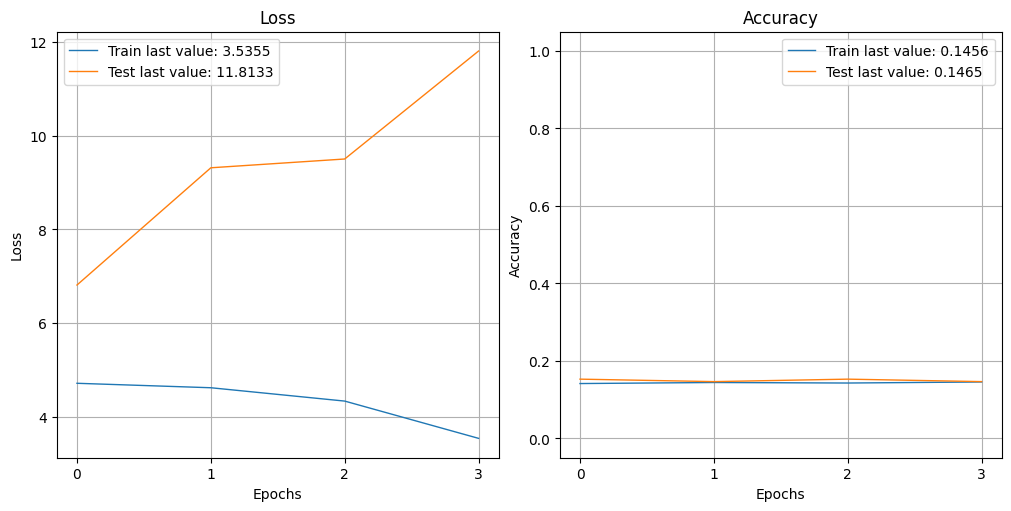

In [53]:
# Afficher l'historique de l'entraînement
show_history(history_mlp)

# Definir le chemin d'export de la figure
dossier_figure = "./figure/"
nom_figure = "history_mlp.png"
chemin_figure_export = os.path.join(dossier_figure, nom_figure)

# Sauvegarder l'historique de l'entraînement
plot_history(history_mlp, path=chemin_figure_export)
plt.close()

## <span style='background:green'>5/ Matrice de confusion</span>

In [59]:
# Retrouver la categorie réelle des images de validation
y_val_num = np.argmax(y_val, axis=1)

# Trouver la categorie prédite des images de validation
y_val_pred = np.argmax(model_mlp.predict(X_val), axis=1)

# Afficher les 10 premières catégories réelles et prédites
print("Categorie reelle : ", y_val_num[:30], "\n")
print("Categorie prédite : ", y_val_pred[:30])

5/5 [==============================] - 0s 4ms/step
Categorie reelle :  [5 1 0 4 1 4 4 0 1 0 1 0 0 4 3 6 3 6 5 0 5 6 0 5 5 5 5 4 0 2] 

Categorie prédite :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]



Correspondance des clusters :  [5 4 0 0 0 0 0]


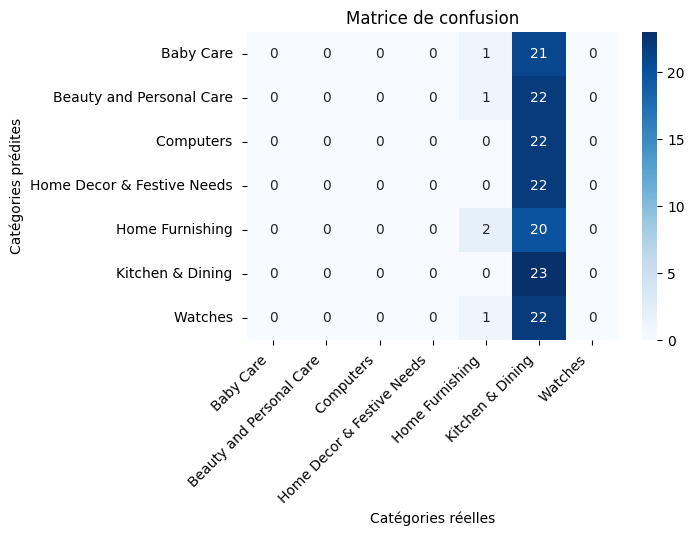

              precision    recall  f1-score   support

           0       1.00      0.00      0.00        22
           1       1.00      0.00      0.00        23
           2       1.00      0.00      0.00        22
           3       1.00      0.00      0.00        22
           4       0.40      0.09      0.15        22
           5       0.15      1.00      0.26        23
           6       1.00      0.00      0.00        23

    accuracy                           0.16       157
   macro avg       0.79      0.16      0.06       157
weighted avg       0.79      0.16      0.06       157



In [62]:
# Verifier la correspondance des clusters
y_val_pred_transform = conf_mat_transform_argmax(y_val_num, y_val_pred)

# Afficher la matrice de confusion et le rapport de classification
conf_mat_mlp = matrice_conf_et_rapport(
    y_val_num,
    y_val_pred_transform,
    categories
    )

# <span style='background:blue'>Etape 4 : CNN</span>

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Créer le modèle
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model_cnn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    )

# Afficher un résumé du modèle
print(model_cnn.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 30752)             0         
                                                                 
 dense_35 (Dense)            (None, 128)               3936384   
                                                                 
 dense_36 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3937409 (15.02 MB)
Trainable params: 3937409 (15.02 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

# <span style='background:blue'>Etape 5 : Transfer learning VGG-16</span>

Nous construisons un modèle de classification d'images en réalisant un
**transfer learning** à partir du modèle VGG-16 qui a été entrainé sur un
jeu de données ImageNet de plus d'1 million d'images.

Ce modèle est composé de 16 couches de convolution et de 3 couches
fully connected.

Il classe les images (224 x 224 pixels) en 1000 catégories différentes.


## <span style='background:green'>Etape 1 : Prétraitement des données</span>

Nous appliquons un prétraitement des données pour les mettre dans un format
adapté au modèle de classification supervisée avec un VGG16.

Le pre-processing des images pour VGG-16 consiste à :
- Convertir l'image en tableau NumPy (si necessaire)
- Normaliser les pixels de l'image pour VGG-16 :
    - Mettre à l'echelle entre -1 et 1 (soustraire valeur moyenne des
    des pixels sur le canaux RGB du jeu de données ImageNet)
    - inverser les canaux RGB en BGR

In [ ]:
# Préparer les images pour l'entraînement du VGG-16
images_np = image_prep_fct(df_image, 'vgg16')
print(images_np.shape)


## <span style='background:green'>1/ création du modèle</span>

Nous créons un modèle de classification d'images en réalisant un
**transfer learning** à partir du modèle VGG-16. Ce dernier est importé
**sans** les 3 couches fully connected. Les **poids** du modèle sont initialisés
avec les poids du modèle entrainé sur ImageNet.

Le modèle VGG16 est utilisé comme extracteur de caractéristiques,
et 4 nouvelles couches sont ajoutées à sa sortie :
- 1 couche de **GlobalAveragePooling2D** pour convertir les features en un
  vecteur 1D
- 1 couche **Dense** de 256 neurones et une fonction d'activation **relu**
- 1 couche **Dropout** pour désactiver 50% des neurones
- 1 couche **Dense** de 7 neurones et une fonction d'activation **softmax**
  pour la classification

  Nous ajoutons 3 callbacks :
  - **ModelCheckpoint** pour sauvegarder le modèle avec la meilleure loss
  - **EarlyStopping** pour arrêter l'entrainement si la loss ne diminue plus
  - **TrainingPlot** pour afficher les courbes pendant l'entrainement

In [13]:
# Création du modèle
with tf.device('/gpu:0'):
    model_tl_vgg16_noDA = creation_modele_transfer_vgg16()

# Callback 1 : Enregistrer le meilleur modèle (poids lorsque val_loss minimale)
chemin_modele_export = "./modele_ML/model_tl_vgg16_noDA_best_weights.h5"
checkpoint = ModelCheckpoint(
    chemin_modele_export,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
    )

# Callback 2 : Arreter entrainement si val_loss ne diminue plus apres 3 epochs
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# Assigner les callbacks à la méthode fit() du modele
callbacks_list = [checkpoint, es]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## <span style='background:green'>2/ entrainement du modèle</span>

Nous entrainons le modèle avec les paramètres suivants :
- **epochs** : 15
- **batch_size** : 64
- **callbacks** : ModelCheckpoint, EarlyStopping, TrainingPlot

Nombre de GPU AMD disponibles :  1 

Epoch 1/15
12/12 [==============================] - ETA: 0s - loss: 5.1841 - accuracy: 0.4639
Epoch 1: val_loss improved from inf to 1.95878, saving model to ./modele_ML\model1_best_weights.h5


c:\Users\pierr\VSC_Projects\Projet6_OCR_DataScientist-\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


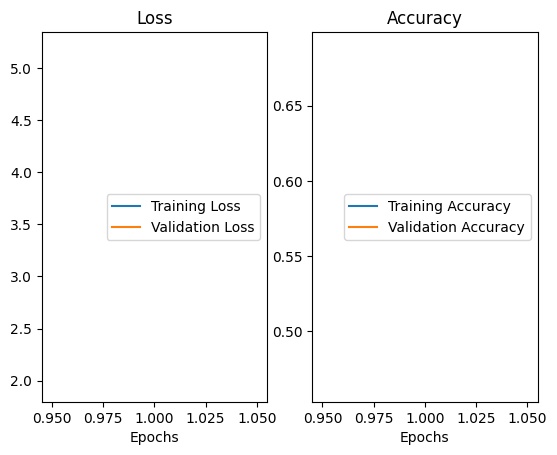

12/12 [==============================] - 123s 10s/step - loss: 5.1841 - accuracy: 0.4639 - val_loss: 1.9588 - val_accuracy: 0.6879
Epoch 2/15
12/12 [==============================] - ETA: 0s - loss: 1.7414 - accuracy: 0.7170
Epoch 2: val_loss improved from 1.95878 to 1.10596, saving model to ./modele_ML\model1_best_weights.h5


<Figure size 640x480 with 0 Axes>

12/12 [==============================] - 118s 10s/step - loss: 1.7414 - accuracy: 0.7170 - val_loss: 1.1060 - val_accuracy: 0.7834
Epoch 3/15
12/12 [==============================] - ETA: 0s - loss: 1.0739 - accuracy: 0.7633
Epoch 3: val_loss improved from 1.10596 to 1.05337, saving model to ./modele_ML\model1_best_weights.h5


<Figure size 640x480 with 0 Axes>

12/12 [==============================] - 105s 9s/step - loss: 1.0739 - accuracy: 0.7633 - val_loss: 1.0534 - val_accuracy: 0.7898
Epoch 4/15
12/12 [==============================] - ETA: 0s - loss: 0.8604 - accuracy: 0.7810
Epoch 4: val_loss improved from 1.05337 to 0.93092, saving model to ./modele_ML\model1_best_weights.h5


<Figure size 640x480 with 0 Axes>

12/12 [==============================] - 104s 9s/step - loss: 0.8604 - accuracy: 0.7810 - val_loss: 0.9309 - val_accuracy: 0.8025
Epoch 5/15
12/12 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.8503
Epoch 5: val_loss did not improve from 0.93092


<Figure size 640x480 with 0 Axes>

12/12 [==============================] - 102s 9s/step - loss: 0.6099 - accuracy: 0.8503 - val_loss: 0.9541 - val_accuracy: 0.7771
Epoch 6/15
12/12 [==============================] - ETA: 0s - loss: 0.4029 - accuracy: 0.8844
Epoch 6: val_loss did not improve from 0.93092


<Figure size 640x480 with 0 Axes>

12/12 [==============================] - 101s 9s/step - loss: 0.4029 - accuracy: 0.8844 - val_loss: 0.9750 - val_accuracy: 0.8153
Epoch 7/15
12/12 [==============================] - ETA: 0s - loss: 0.3665 - accuracy: 0.8844
Epoch 7: val_loss improved from 0.93092 to 0.85272, saving model to ./modele_ML\model1_best_weights.h5


<Figure size 640x480 with 0 Axes>

12/12 [==============================] - 100s 8s/step - loss: 0.3665 - accuracy: 0.8844 - val_loss: 0.8527 - val_accuracy: 0.8280
Epoch 8/15
12/12 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9170
Epoch 8: val_loss did not improve from 0.85272


<Figure size 640x480 with 0 Axes>

12/12 [==============================] - 100s 8s/step - loss: 0.2700 - accuracy: 0.9170 - val_loss: 0.8675 - val_accuracy: 0.7898
Epoch 9/15
12/12 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.9211
Epoch 9: val_loss did not improve from 0.85272


<Figure size 640x480 with 0 Axes>

12/12 [==============================] - 100s 8s/step - loss: 0.2819 - accuracy: 0.9211 - val_loss: 0.9356 - val_accuracy: 0.7834
Epoch 10/15
12/12 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9388
Epoch 10: val_loss did not improve from 0.85272


<Figure size 640x480 with 0 Axes>

12/12 [==============================] - 102s 9s/step - loss: 0.1866 - accuracy: 0.9388 - val_loss: 0.9140 - val_accuracy: 0.8025
Epoch 10: early stopping


In [14]:
# Afficher les GPU AMD disponibles
amd_gpus = get_available_amd_gpus()
print("Nombre de GPU AMD disponibles : ", len(amd_gpus), "\n")

# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):

    history_tl_vgg16_noDA = model_tl_vgg16_noDA.fit(
        X_train,
        y_train,
        epochs=15,
        batch_size=64,
        callbacks=callbacks_list,
        validation_data=(X_val, y_val),
        verbose=1
        )

## <span style='background:green'>3/ Comparatif des accuracy</span>

In [15]:
# Evaluation du modèle (dernier epoch) sur les données de train
loss, accuracy = model_tl_vgg16_noDA.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.3f}\n".format(accuracy))

# Evaluation du modèle (dernier epoch) sur les données de validation
loss, accuracy = model_tl_vgg16_noDA.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.3f}".format(accuracy))

23/23 [==============================] - 84s 4s/step - loss: 0.0183 - accuracy: 0.9946
Training Accuracy: 0.995

5/5 [==============================] - 17s 3s/step - loss: 0.9140 - accuracy: 0.8025
Validation Accuracy:  0.803


In [16]:
# Charger les poids du meilleur modèle
model_tl_vgg16_noDA.load_weights(chemin_modele_export)

# Evaluation meilleur modèle sur les données de validation
loss, accuracy = model_tl_vgg16_noDA.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.3f}".format(accuracy))

# Evaluation meilleur modèle sur les données de test
loss, accuracy = model_tl_vgg16_noDA.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.3f}".format(accuracy))

Validation Accuracy :  0.828
Test Accuracy       :  0.835


## <span style='background:green'>4/ Plot loss et accuracy</span>

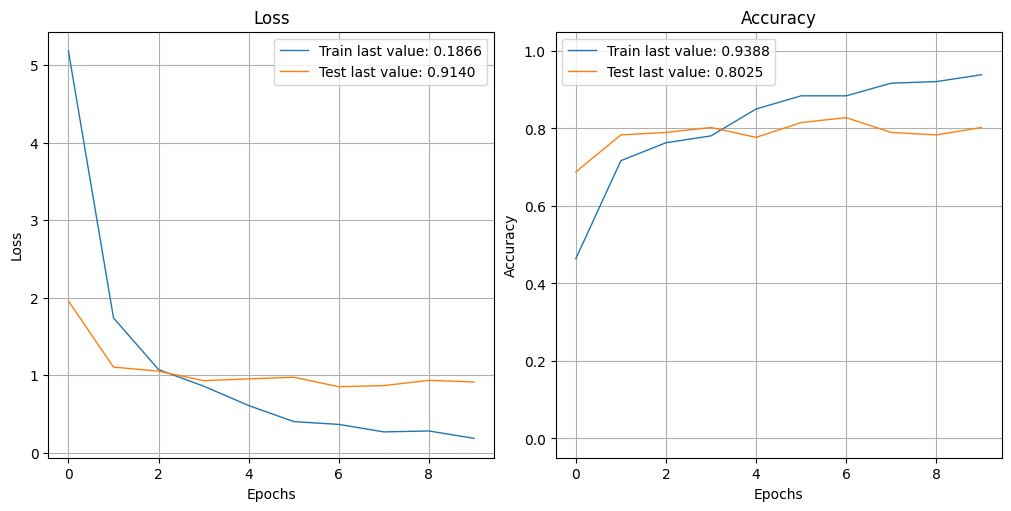

In [17]:
# Afficher l'historique de l'entraînement
show_history(history_tl_vgg16_noDA)

# Definir le chemin d'export de la figure
dossier_figure = "./figure/"
nom_figure = "history_tl_vgg16_noDA.png"
chemin_figure_export = os.path.join(dossier_figure, nom_figure)

# Sauvegarder l'historique de l'entraînement
plot_history(history_tl_vgg16_noDA, path=chemin_figure_export)
plt.close()

## <span style='background:green'>5/ Matrice de confusion</span>

In [54]:
# Retrouver la categorie réelle des images de validation
y_val_num = np.argmax(y_val, axis=1)

# Trouver la categorie prédite des images de validation
y_val_pred = np.argmax(model_tl_vgg16_noDA.predict(X_val), axis=1)

# Afficher les 10 premières catégories réelles et prédites
print("Categorie reelle : ", y_val_num[:30], "\n")
print("Categorie prédite : ", y_val_pred[:30])

NameError: name 'model_tl_vgg16_noDA' is not defined


Correspondance des clusters :  [0 1 2 3 4 5 6]


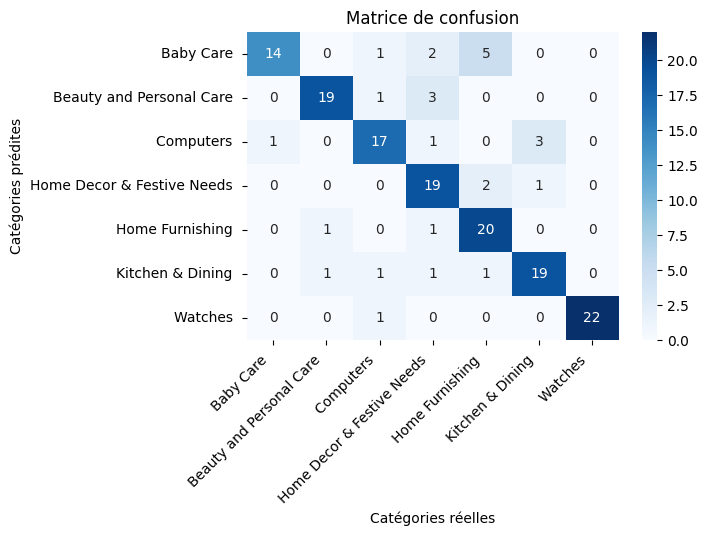

              precision    recall  f1-score   support

           0       0.93      0.64      0.76        22
           1       0.90      0.83      0.86        23
           2       0.81      0.77      0.79        22
           3       0.70      0.86      0.78        22
           4       0.71      0.91      0.80        22
           5       0.83      0.83      0.83        23
           6       1.00      0.96      0.98        23

    accuracy                           0.83       157
   macro avg       0.84      0.83      0.83       157
weighted avg       0.84      0.83      0.83       157



In [19]:
# Verifier la correspondance des clusters
y_val_pred_transform = conf_mat_transform_argmax(y_val_num, y_val_pred)

# Afficher la matrice de confusion et le rapport de classification
conf_mat_tl_vgg16_noDA = matrice_conf_et_rapport(
    y_val_num,
    y_val_pred_transform,
    categories
    )

# # Creer la matrice de confusion
# conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)

# # Transformation en dataFrame
# conf_mat_trans_df = pd.DataFrame(
#     conf_mat,
#     index=[label for label in sorted(categories)],
#     columns=[label for label in sorted(categories)]
#     )

# # Afficher la matrice de confusion
# plt.figure(figsize=(6, 4))
# sns.heatmap(conf_mat_trans_df, annot=True, cmap="Blues")
# plt.title('Matrice de confusion')
# plt.xlabel('Catégories réelles')
# plt.ylabel('Catégories prédites')
# plt.xticks(rotation=45, ha='right')
# plt.show()

# # Afficher le rapport de classification
# print(metrics.classification_report(y_val_num, y_val_pred_transform))

# <span style='background:blue'>Etape 6 : Data augmentation</span>

# <span style='background:blue'>Etape 7 : Transfer learning VGG-16 + Data augmentation</span>

## <span style='background:green'>1/ création du modèle</span>

Nous construisons un modèle de classification d'images en réalisant un
transfer learning à partir du modèle VGG-16 et avec les données augmentées.

## <span style='background:green'>2/ entrainement du modèle</span>

## <span style='background:green'>3/ Comparatif des accuracy</span>

## <span style='background:green'>4/ Plot loss et accuracy</span>

## <span style='background:green'>5/ Matrice de confusion</span>

# <span style='background:blue'>Etape 8 : Comparaison des résultats</span>


# <span style='background:blue'>Conclusion</span>


Compétence OCR:

**Définir la stratégie d’élaboration d’un modèle d'apprentissage profond, concevoir ou ré-utiliser des
modèles pré-entraînés (transfer learning) et entraîner des modèles afin de réaliser une analyse
prédictive.**
- CE1 Le candidat a défini sa stratégie d’élaboration d’un modèle pour répondre à un besoin métier (par
exemple : choix de conception d’un modèle ou ré-utilisation de modèles pré-entraînés).
- CE2 Le candidat a identifié la ou les cibles.
- CE3 Le candidat a réalisé la séparation du jeu de données en jeu d’entraînement, jeu de validation et
jeu de test.
- CE4 Le candidat s'est assuré qu'il n’y a pas de fuite d’information entre les jeux de données
(entraînement, validation et test).
- CE5 Le candidat a testé plusieurs modèles d’apprentissage profond (par exemple à l’aide de la librairie
Tensorflow / Keras) en partant du plus simple vers les plus complexes.
- CE6 Le candidat a mis en oeuvre des modèles à partir de modèles pré-entraînés (technique de
Transfer Learning)

**Évaluer la performance des modèles d’apprentissage profond selon différents critères (scores,
temps d'entraînement, etc.) afin de choisir le modèle le plus performant pour la problématique
métier.**
- CE1 Le candidat a choisi une métrique adaptée à la problématique métier, et sert à évaluer la
performance des modèles
- CE2 Le candidat a explicité le choix de la métrique d’évaluation
- CE3 Le candidat a évalué la performance d’un modèle de référence et sert de comparaison pour
évaluer la performance des modèles plus complexes
- CE4 Le candidat a calculé, hormis la métrique choisie, au moins un autre indicateur pour comparer les
modèles (par exemple : le temps nécessaire pour l’entraînement du modèle)
- CE5 Le candidat a optimisé au moins un des hyperparamètres du modèle choisi (par exemple : le choix
de la fonction Loss, le Batch Size, le nombre d'Epochs)

**Utiliser des techniques d’augmentation des données afin d'améliorer la performance des modèles.**
- CE1 Le candidat a utilisé plusieurs techniques d’augmentation des données (ex. pour des images :
rotation, changement d’échelle, ajout de bruit…).
- CE2 Le candidat a présenté une synthèse comparative des améliorations de performance grâce aux
différentes techniques d'augmentation de données utilisées (maîtrise de l’overfitting, meilleur score).

In [20]:
# Afficher temps d'exécution du notebook
calculer_duree_notebook(start_time)

Durée totale pour faire tourner le notebook : 20 minute(s) 35 seconde(s)
